# Modeling

In [168]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)
%matplotlib inline

In [169]:
cases = pd.read_csv('Data.nosync/Similar_TM.csv')
cases.sample(20)

TM_A                            TM_B  target
296            BREXIT                      BREXIT BOX       0
291         SPRAY DRY                       SUPER DRY       0
280            ITP UK                             ITP       1
355   No Gunk No Junk               No Gunk Just Funk       0
375       SPORTY TOTS                     Sporti Tots       1
257             TIAMA                           TIANA       1
124           Pinkies                          PIMKIE       1
7         Woody Stout                 Woody Brown Ale       1
184              ENVY                    ANGEL’S ENVY       1
443             ADAPT               ADAPT ACCOUNTANCY       1
414  SOPHIA DE-MARTIN                          SOPHIE       0
357  MARAS DONDURMASI  MARAS DONDUMAYI ADIYLA ISTEVIN       1
307      DRAGON’S DEN         Dragons Investment Show       0
275             MILAN                    MILAN SWEETS       1
111        Amberstone                     Bridgestone       1
268     TOAST IT NOTE                         POST-IT       1
225          Vapouriz                       Vaporized       1
258           WELLBOX                      WELLBLOCKS       1
326   MARK ADAMS NO 1                         MARK 10       0
108             DWELL                   DWELL STUDENT       1

In [170]:
import unidecode
from fuzzywuzzy import fuzz
import jellyfish

from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, PhoneticEditDistance)

from abydos.phonetic import PSHPSoundexFirst, Ainsworth
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

In [171]:
iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
higuera_mico = HigueraMico()
sift4 = Sift4()
eudex = Eudex()
aline = ALINE()
phonetic_edit = PhoneticEditDistance()

In [172]:
algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro, higuera_mico, sift4, eudex,
         aline, phonetic_edit]

algo_names = ['iterativesubstring', 'bisim', 'discountedlevenshtein', 'prefix', 'lcsstr', 'mlipns', 'strcmp95', 'mra',
              'editex', 'saps', 'flexmetric', 'jaro', 'higueramico', 'sift4', 'eudex', 'aline',
              'phoneticeditdistance']

In [173]:
from abydos.phones import *

In [174]:
def sum_ipa(name_a, name_b):
    feat1 = ipa_to_features(pe.encode(name_a))
    feat2 = ipa_to_features(pe.encode(name_b))
    if len(feat1) <= 1:
        score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/1
    else:    
        score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/len(feat1)
    return score

In [175]:
import re

In [176]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def featurize(df):
    if len(df.columns)==3:
        df.columns=['a', 'b', 'target']
    elif len(df.columns)==2:
        df.columns=['a', 'b']
    else:
        df = df.rename(columns={df.columns[0]: 'a', df.columns[1]: 'b' })
        
    df['TM_A'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['a']).lower()), axis=1)
    df['TM_B'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['b']).lower()), axis=1)
    
    df['partial'] = df.apply(lambda row: fuzz.partial_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_sort'] = df.apply(lambda row: fuzz.token_sort_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_set'] = df.apply(lambda row: fuzz.token_set_ratio(row.TM_A,row.TM_B), axis=1)
    
    df['sum_ipa'] = df.apply(lambda row: sum_ipa(row.TM_A,row.TM_B), axis=1)
    
    # Jellyfish levenshtein
    df['levenshtein']= df.apply(lambda row: jellyfish.levenshtein_distance(row.TM_A,row.TM_B), axis=1)
    # Scale Levenshtein column
    scaler = MinMaxScaler()
    df['levenshtein'] = scaler.fit_transform(df['levenshtein'].values.reshape(-1,1))

    # Jellyfish phoneme
    df['metaphone'] = df.apply(
        lambda row: 1 if jellyfish.metaphone(row.TM_A)==jellyfish.metaphone(row.TM_B) else 0, axis=1)
    df['nysiis'] = df.apply(
        lambda row: 1 if jellyfish.nysiis(row.TM_A)==jellyfish.nysiis(row.TM_B) else 0, axis=1)
    df['mtch_rtng_cdx'] = df.apply(
        lambda row: 1 if jellyfish.match_rating_codex(row.TM_A)==jellyfish.match_rating_codex(row.TM_B) else 0, axis=1)
    
    df['pshp_soundex_first'] = df.apply(
        lambda row: 1 if pshp_soundex_first.encode(row.TM_A)==pshp_soundex_first.encode(row.TM_B) else 0, axis=1)
    
    for i, algo in enumerate(algos):
            df[algo_names[i]] = df.progress_apply(lambda row: algo.sim(row.TM_A, row.TM_B), axis=1)

    
    return df

In [177]:
# featurize(cases)

### Class Balancing  
We can see that the classes are imbalanced, there are more instances of trademark invalidation than are dismissals.

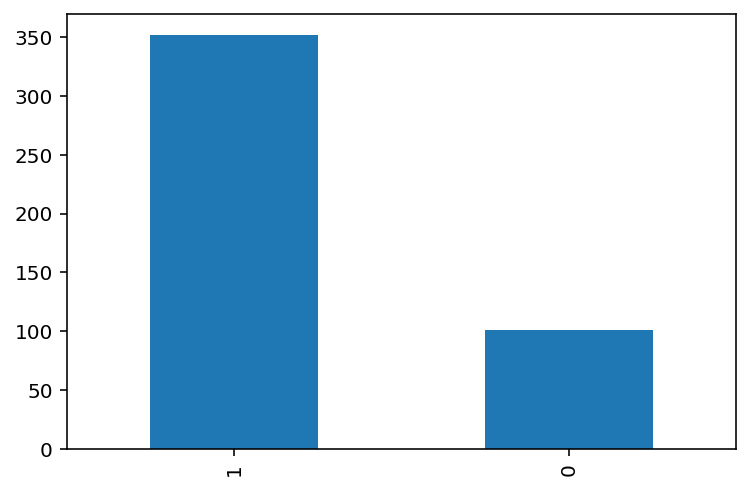

In [178]:
cases['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Unbalanced.png', dpi = 300)

In [179]:
from itertools import combinations
import random
random.seed(42)


In [180]:
# Use combinatorics to generate negative class
pos_cases = cases[cases['target'] == 1]

case_names = pos_cases.loc[:, 'TM_A':'TM_B'].values.tolist()
unique_cases = list(set([item for items in case_names for item in items]))
alt_pairs = list(zip(pos_cases.TM_A, pos_cases.TM_B))+ list(zip(pos_cases.TM_B, pos_cases.TM_A))
comb = list(combinations(unique_cases, 2))
nonmatch_cases = list(set(comb) - set(alt_pairs))
# Undersample the negative class for 1:4 class imbalance instead of 1:1000 extreme class imbalance
nonmatch_cases = pd.DataFrame(random.choices(nonmatch_cases, k=250), columns=['TM_A', 'TM_B']) # Originally was 1200

nonmatch_cases

TM_A                 TM_B
0                            MICRONCLEAN                 Zero
1        LA FRANCAISE investing together               OPARUS
2                              KNOCK OUT  SHOE BOUDOIR LONDON
3                                 J WELL                Canya
4                        Horse of London            FENESTRAE
..                                   ...                  ...
245                               Dragon                MEDAC
246                              MONSTER          MICRONCLEAN
247                              Silarom            EASYGROUP
248                                   HM               JUSTBE
249  POP Positive Organisations & People             RAWPIXEL

[250 rows x 2 columns]

In [181]:
print('positive class ratio 1:{}'.format(int(len(nonmatch_cases)/len(pos_cases))))

positive class ratio 1:0


In [182]:
nonmatch_cases.sample(20)

TM_A               TM_B
244                             GOGO               Next
209                               GE            CRUSH’D
188                        SYNDICATE            Potters
67                           CIRCUIT              OPALS
37                     Cheeky Indian              VIFON
159                               HM          All Stars
25                            Nestea            VESPERS
6                               Dank          ICE WATCH
55                  LIFESTYLE FLOORS       DIXY CHICKEN
133              SHOE BOUDOIR LONDON          Permanize
148                  ELEGANT RESORTS          All Stars
204                         J/SLIDES             Sabis.
212                          FWDVIEW         Red Dragon
33                        BUBBLECARD            Nivalin
4                    Horse of London          FENESTRAE
112                              IBM  BRITISH GREEN GAS
124                         HAMILTON          ICE CREAM
222  LA FRANCAISE investing together            CIRCUIT
80                             Cview           Cephalus
16                             SEVEN               AURA

In [183]:
# Negative Class
nonmatch_cases['target'] = 0
df = pd.concat([pos_cases, nonmatch_cases])
# non_match_cases = None
# pos_cases = None

# Add true negatives
neg_cases = cases[cases['target'] == 0]
class_balanced = pd.concat([df, neg_cases])

class_balanced.sample(20)

# class_balanced[class_balanced['TM_B'].str.len()!=0]


TM_A                     TM_B  target
45                     Zlide              Logic Slide       1
208                     GOGO                     COGO       1
412                  LUMESSE      LUMENE NATURAL CODE       1
183            Fizz Fitness                  Fizz Bug       1
239                  CIRCUIT                  CIRQUIT       1
134               TREADSTONE                    STONE       1
439                 CITIBANK  CITIGATE COMMUNICATIONS       1
99                     Karex                   carexy       1
7                     SLYDES            TOAST IT NOTE       0
275                    MILAN             MILAN SWEETS       1
214                     COCO           Coco’s Liberty       1
288  Ocean Spray Cranberries       Ocean Garden Prods       0
362                       C3            C3 EX MACHINA       1
267                     VION                    VIFON       1
359                  CASTELL                 CASTELLI       1
200                      RAW                   RAWKUS       1
88                   ELYSIUM                     SUB4       0
323                 StoneRez                 STONPLUS       0
15                     Karex                RedInside       0
115                JOBZGENIE            Platinum Plus       0

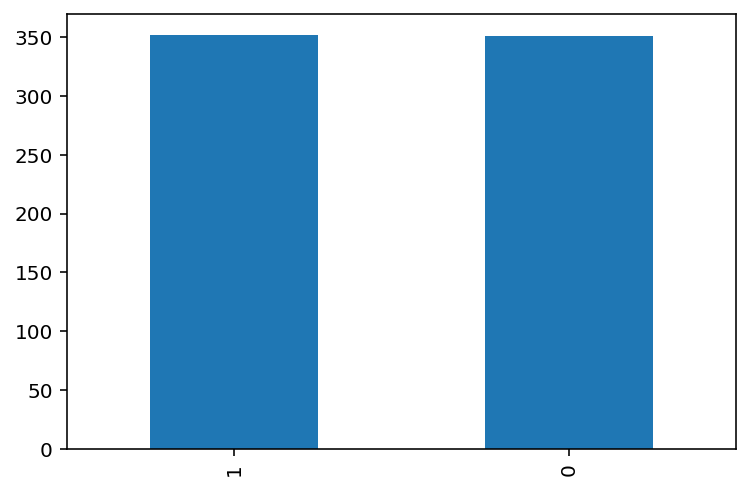

In [184]:
class_balanced['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Balanced.png', dpi = 300)

In [185]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

df = featurize(class_balanced)
df.sample(20)

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


a                               b  target  \
315                Amigos                       CASAMIGOS       0   
134             RedInside                  Gourmet Halwai       0   
250     BRITISH GREEN GAS                     BRITISH GAS       1   
357      MARAS DONDURMASI  MARAS DONDUMAYI ADIYLA ISTEVIN       1   
16                  SEVEN                            AURA       0   
54                  Boost                      Boost shot       1   
289  THE HYDE PARK DY GIN                HYDE PARK CORNER       0   
218              HAMILTON               HAMILTON & INCHES       1   
76                   KINK                     KINKCENTRAL       1   
134            TREADSTONE                           STONE       1   
445              DA VINCI                           VINCI       0   
42                 CAMcap                           ADAPT       0   
118               GREYBOX                            GREY       1   
88              RedInside                          Inside       1   
140            PROVENTURE                           OMEGA       0   
34         Coco’s Liberty                           OPUS        0   
310            Casablanca       Weekend in Casablanca Tea       0   
419             LION HEAD                      TRIPL LION       0   
64                  Jaded                 Woody Brown Ale       0   
30                 CRUSHA                       Starbucks       0   

                 TM_A                         TM_B  partial  tkn_sort  \
315            amigos                    casamigos      100        80   
134         redinside                gourmethalwai       22        27   
250   britishgreengas                   britishgas       80        80   
357   marasdondurmasi  marasdondumayiadiylaistevin       87        67   
16              seven                         aura        0         0   
54              boost                    boostshot      100        71   
289  thehydeparkdygin               hydeparkcorner       67        60   
218          hamilton               hamiltoninches      100        73   
76               kink                  kinkcentral      100        53   
134        treadstone                        stone      100        67   
445           davinci                        vinci      100        83   
42             camcap                        adapt       60        55   
118           greybox                         grey      100        73   
88          redinside                       inside      100        80   
140        proventure                        omega       40        27   
34       cocosliberty                         opus       50        25   
310        casablanca       weekendincasablancatea      100        62   
419          lionhead                    tripllion       50        47   
64              jaded                woodybrownale       40        22   
30             crusha                    starbucks       50        40   

     tkn_set   sum_ipa  levenshtein  metaphone  nysiis  mtch_rtng_cdx  \
315       80  0.543011     0.096774          0       0              0   
134       27  0.641129     0.354839          0       0              0   
250       80  0.617866     0.161290          0       0              0   
357       67  0.916129     0.451613          0       0              0   
16         0  0.332258     0.161290          0       0              0   
54        71  1.000000     0.129032          0       0              0   
289       60  0.618280     0.290323          0       0              0   
218       73  1.000000     0.193548          0       0              0   
76        53  1.000000     0.225806          0       0              0   
134       67  0.459677     0.161290          0       0              0   
445       83  0.488479     0.064516          0       0              0   
42        55  0.483871     0.129032          0       0              0   
118       73  0.500000     0.096774          0       0              0   
88        80  0.48

#### Export clean data to csv

In [112]:
# df.to_csv('Data.nosync/TM_features.csv', index=False)  

In [186]:
y = df.target
X = df.drop(columns = 'target')

In [187]:
from sklearn.model_selection import train_test_split

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [189]:
#X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1)

## TPOT AutoML pipeline

In [190]:
from tpot import TPOTClassifier

In [191]:
# pipeline_optimizer = TPOTClassifier(
#         scoring = 'f1', 
#         generations=100,
#         verbosity=2,
#         n_jobs=-1   # Utilizes all available CPU cores
#         ) 
# pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

In [192]:
# print(pipeline_optimizer.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test))

### Export TPOT pipeline

In [193]:
# pipeline_optimizer.export('tpot_exported_calssifier_pipeline.py')

### Load TPOT pipeline

In [194]:
df_TPOT = df.drop(columns = ['a','b','TM_A','TM_B'])
df_TPOT

target  partial  tkn_sort  tkn_set   sum_ipa  levenshtein  metaphone  \
0         1       57        50       50  0.658986     0.161290          0   
1         1       38        38       38  0.691532     0.161290          0   
2         1       89        73       73  0.806452     0.096774          0   
3         1       83        83       83  0.895161     0.096774          0   
4         1       74        65       65  0.743176     0.290323          0   
..      ...      ...       ...      ...       ...          ...        ...   
437       0       62        43       43  0.905242     0.483871          0   
444       0       80        73       73  0.925806     0.064516          0   
445       0      100        83       83  0.488479     0.064516          0   
446       0      100        80       80  0.615385     0.129032          0   
450       0       75        80       80  0.516129     0.064516          0   

     nysiis  mtch_rtng_cdx  pshp_soundex_first  iterativesubstring     bisim  \
0         0              0                   0            0.485480  0.388889   
1         0              0                   0            0.050000  0.437500   
2         0              0                   0            0.821263  0.583333   
3         0              0                   1            0.884677  0.833333   
4         0              0                   0            0.951613  0.588235   
..      ...            ...                 ...                 ...       ...   
437       0              0                   1            0.577381  0.275000   
444       0              0                   1            0.875809  0.750000   
445       0              0                   0            0.916667  0.642857   
446       0              0                   1            0.940000  0.666667   
450       0              0                   0            0.786471  0.583333   

     discountedlevenshtein  prefix    lcsstr  mlipns  strcmp95       mra  \
0                 0.383752   0.000  0.333333     0.0  0.722751  0.666667   
1                 0.366778   0.125  0.250000     0.0  0.633333  0.500000   
2                 0.495199   0.000  0.666667     0.0  0.822222  0.833333   
3                 0.818487   0.750  0.750000     1.0  0.933333  0.500000   
4                 0.472052   0.000  0.529412     0.0  0.700700  0.000000   
..                     ...     ...       ...     ...       ...       ...   
437               0.368095   0.500  0.200000     0.0  0.625000  0.000000   
444               0.732861   0.800  0.666667     1.0  0.915333  0.833333   
445               0.664079   0.000  0.714286     0.0  0.904762  0.833333   
446               0.750388   1.000  0.666667     1.0  0.933333  0.500000   
450               0.708712   0.750  0.500000     1.0  0.922222  0.833333   

       editex      saps  flexmetric      jaro  higueramico     sift4  \
0    0.555556  0.137931    0.566667  0.671958     0.430556  0.444444   
1    0.500000  0.304348    0.400000  0.583333     0.375000  0.375000   
2    0.500000  0.428571    0.600000  0.822222     0.547619  0.666667   
3    0.833333  0.666667    0.833333  0.888889     0.769231  0.833333   
4    0.588235  0.319149    0.538235  0.687675     0.490372  0.588235   
..        ...       ...         ...       ...          ...       ...   
437  0.275000  0.000000    0.417500  0.625000     0.000000  0.250000   
444  0.750000  0.476190    0.691667  0.822222     0.666667  0.666667   
445  0.714286  0.500000    0.800000  0.904762     0.690476  0.714286   
446  0.666667  0.476190    0.708333  0.888889     0.614646  0.666667   
450  0.666667  0.476190    0.683333  0.888889     0.633333  0.666667   

        eudex     aline  phoneticeditdistance  
0    0.654902  0.602128              0.727599  
1    0.916667  0.545455              0.897177  
2    0.786275  0.705882              0.634409  
3    1.000000  0.873529              0.913978  
4    0.463725  0.589655              0.646110  
..        ...       ...                   ...  
437  

In [195]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df_TPOT
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5,
                               min_samples_leaf=10, min_samples_split=3, 
                               n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

results

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0])

In [196]:
def base_model_1(X_train, y_train, X_test, export = False) :
    exported_pipeline = make_pipeline(
    GradientBoostingClassifier(
        learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
    )

    exported_pipeline.fit(X_train, y_train)
    if export==True:
        return exported_pipeline
    else:
        y_pred = exported_pipeline.predict_proba(X_test)
        return [p[1] for p in y_pred]

In [197]:
base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), 
             y_train, X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

[0.21545247181890642,
 0.6988515086822814,
 0.7415409823674208,
 0.18845954058798628,
 0.6570423551922346,
 0.18845954058798628,
 0.18845954058798628,
 0.652201114518473,
 0.3411323646995271,
 0.565798552192003,
 0.21589211079314868,
 0.6184855531558348,
 0.19908937111602407,
 0.20601381971063037,
 0.5810771909607031,
 0.6909273384852707,
 0.7360007248997393,
 0.6807324572192535,
 0.6761399842584253,
 0.6843542431266862,
 0.18768967092944405,
 0.6430793145208078,
 0.18845954058798628,
 0.2220974210135491,
 0.19994224659804172,
 0.38385999782550817,
 0.6950858518488235,
 0.18845954058798628,
 0.6948228395439723,
 0.6582041838574826,
 0.6319336297524891,
 0.6802352857586188,
 0.7312524305442462,
 0.7288025871399952,
 0.20618264347926746,
 0.6538745500968783,
 0.7221041483761274,
 0.6438970063700676,
 0.3152492473714991,
 0.18845954058798628,
 0.5689552806513465,
 0.7419341054741673,
 0.19330212532629834,
 0.37080572343214263,
 0.6041916494292008,
 0.5843817572765501,
 0.2100121765940453,

# K-fold cross validation

In [198]:
from sklearn.model_selection import StratifiedKFold

In [199]:
pd.options.mode.chained_assignment = None

# Stratified K-Folds cross-validator
meta_training = pd.DataFrame()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    oof_pred = X_test[['TM_A', 'TM_B']]
    
    oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
                                      y_train,
                                      X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
    
    oof_pred['target'] = y_test.tolist()
    
    print('completed fold {} of 10'.format(fold))
    fold += 1

    meta_training = meta_training.append(oof_pred)

completed fold 1 of 10
completed fold 2 of 10
completed fold 3 of 10
completed fold 4 of 10
completed fold 5 of 10
completed fold 6 of 10
completed fold 7 of 10
completed fold 8 of 10
completed fold 9 of 10
completed fold 10 of 10


In [200]:
meta_training.sample(20)

TM_A                         TM_B  predict_proba  target
357    marasdondurmasi  marasdondumayiadiylaistevin       0.688016       1
106               loco              theuglykidsclub       0.199814       0
55                 rad                         rads       0.670124       1
308         bailybaily               baillylapierre       0.635325       0
86             moscany             investedtogether       0.194276       0
44           reddragon                       dragon       0.669465       1
245             dragon                        medac       0.196609       0
41        gameofstones                        vifon       0.225555       0
103             camcap                        amcap       0.656653       1
209          doctornow                        drnow       0.687749       1
117        pingperfect                     montnoir       0.194449       0
187              genie                    jobzgenie       0.723719       1
373            disobey                         obey       0.711501       1
66             blendit                       cozirc       0.201190       0
171  togetherforbetter            alltogetherbetter       0.709369       1
370          impericon                     imperial       0.684051       0
162               cogo                     percipio       0.201137       0
12               tiama                     omnilive       0.191455       0
303                cme                     irsiacmf       0.222948       0
244         whitespace         whitespaceautomotive       0.746398       1

### Meta-Model: Logistic Regression

In [201]:
df=featurize(meta_training)

In [202]:
df.sample(20)

a                b  predict_proba  target  \
430                        o               ho       0.680650       1   
57          swisslifeforever     swisslifendk       0.675971       1   
61                    britsa           briska       0.727182       1   
226                     eris  theuglykidsclub       0.199428       0   
303                      cme         irsiacmf       0.222948       0   
196            beatriceperry        beatriceb       0.700486       1   
247                    frill            frijj       0.706810       1   
197                 neverwet         cephalus       0.195839       0   
46                groundsure        sugarzero       0.197724       0   
27         elegantaddressski       britishgas       0.196032       0   
224                  skyrizi           eponim       0.196032       0   
182              wealthsmart   ubssmartwealth       0.540287       1   
274                   wartie          wartner       0.676122       1   
155                   seycos             rush       0.190159       0   
281                woodlands         woodland       0.657392       1   
321                 stonerez         stoncare       0.692163       0   
66                   tlclive      tlctraining       0.604910       1   
159         redbullbbqgrills          redbull       0.715239       1   
96   belgravesathompsonhotel      helloenergy       0.191455       0   
103                   camcap            amcap       0.656653       1   

                        TM_A             TM_B  partial  tkn_sort  tkn_set  \
430                        o               ho      100        67       67   
57          swisslifeforever     swisslifendk       75        64       64   
61                    britsa           briska       83        83       83   
226                     eris  theuglykidsclub       50        32       32   
303                      cme         irsiacmf       67        36       36   
196            beatriceperry        beatriceb       89        73       73   
247                    frill            frijj       60        60       60   
197                 neverwet         cephalus       12        12       12   
46                groundsure        sugarzero       44        42       42   
27         elegantaddressski       britishgas       30        22       22   
224                  skyrizi           eponim       17        15       15   
182              wealthsmart   ubssmartwealth       55        48       48   
274                   wartie          wartner       83        77       77   
155                   seycos             rush       25        20       20   
281                woodlands         woodland      100        94       94   
321                 stonerez         stoncare       75        75       75   
66                   tlclive      tlctraining       57        44       44   
159         redbullbbqgrills          redbull      100        61       61   
96   belgravesathompsonhotel      helloenergy       36        29       29   
103                   camcap            amcap      100        91       91   

      sum_ipa  levenshtein  metaphone  nysiis  mtch_rtng_cdx  \
430  0.532258     0.032258          0       0              0   
57   0.711982     0.225806          0       0              0   
61   0.948925     0.064516          0       0              0   
226  0.713710     0.387097          0       0              0   
303  0.741935     0.193548          0       0              0   
196  0.663978     0.161290          0       0              0   
247  0.912903     0.064516          0       0              0   
197  0.743952     0.225806          0       0              0   
46   0.653226     0.290323          0       0              0   
27   0.475806     0.483871          0       0              0   
224  0.677419     0.193548          0       0              0   
182  0.719758     0.354839          0       0              0   
274  0.771889     0.064516          0       0              0   


### Evaluate Gradient Boosting Classifier

In [203]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

gb_clf2 = GradientBoostingClassifier(learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
gb_clf2.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)
predictions = gb_clf2.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[28  7]
 [ 2 33]]
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        35
           1       0.82      0.94      0.88        35

    accuracy                           0.87        70
   macro avg       0.88      0.87      0.87        70
weighted avg       0.88      0.87      0.87        70



In [204]:
predictions

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1])

In [205]:
# df_confusion.to_csv('TM_GBC_Confusion_matrix.csv')

In [206]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.932')

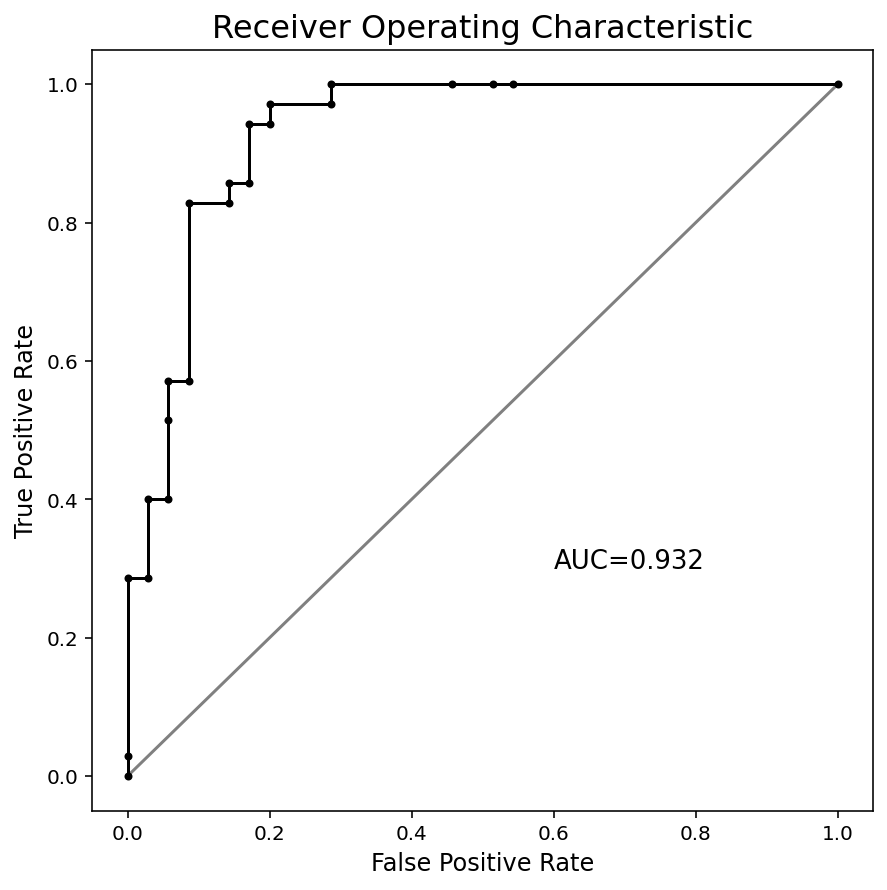

In [207]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = gb_clf2.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('TM_GBC_ROC.png', dpi = 300)

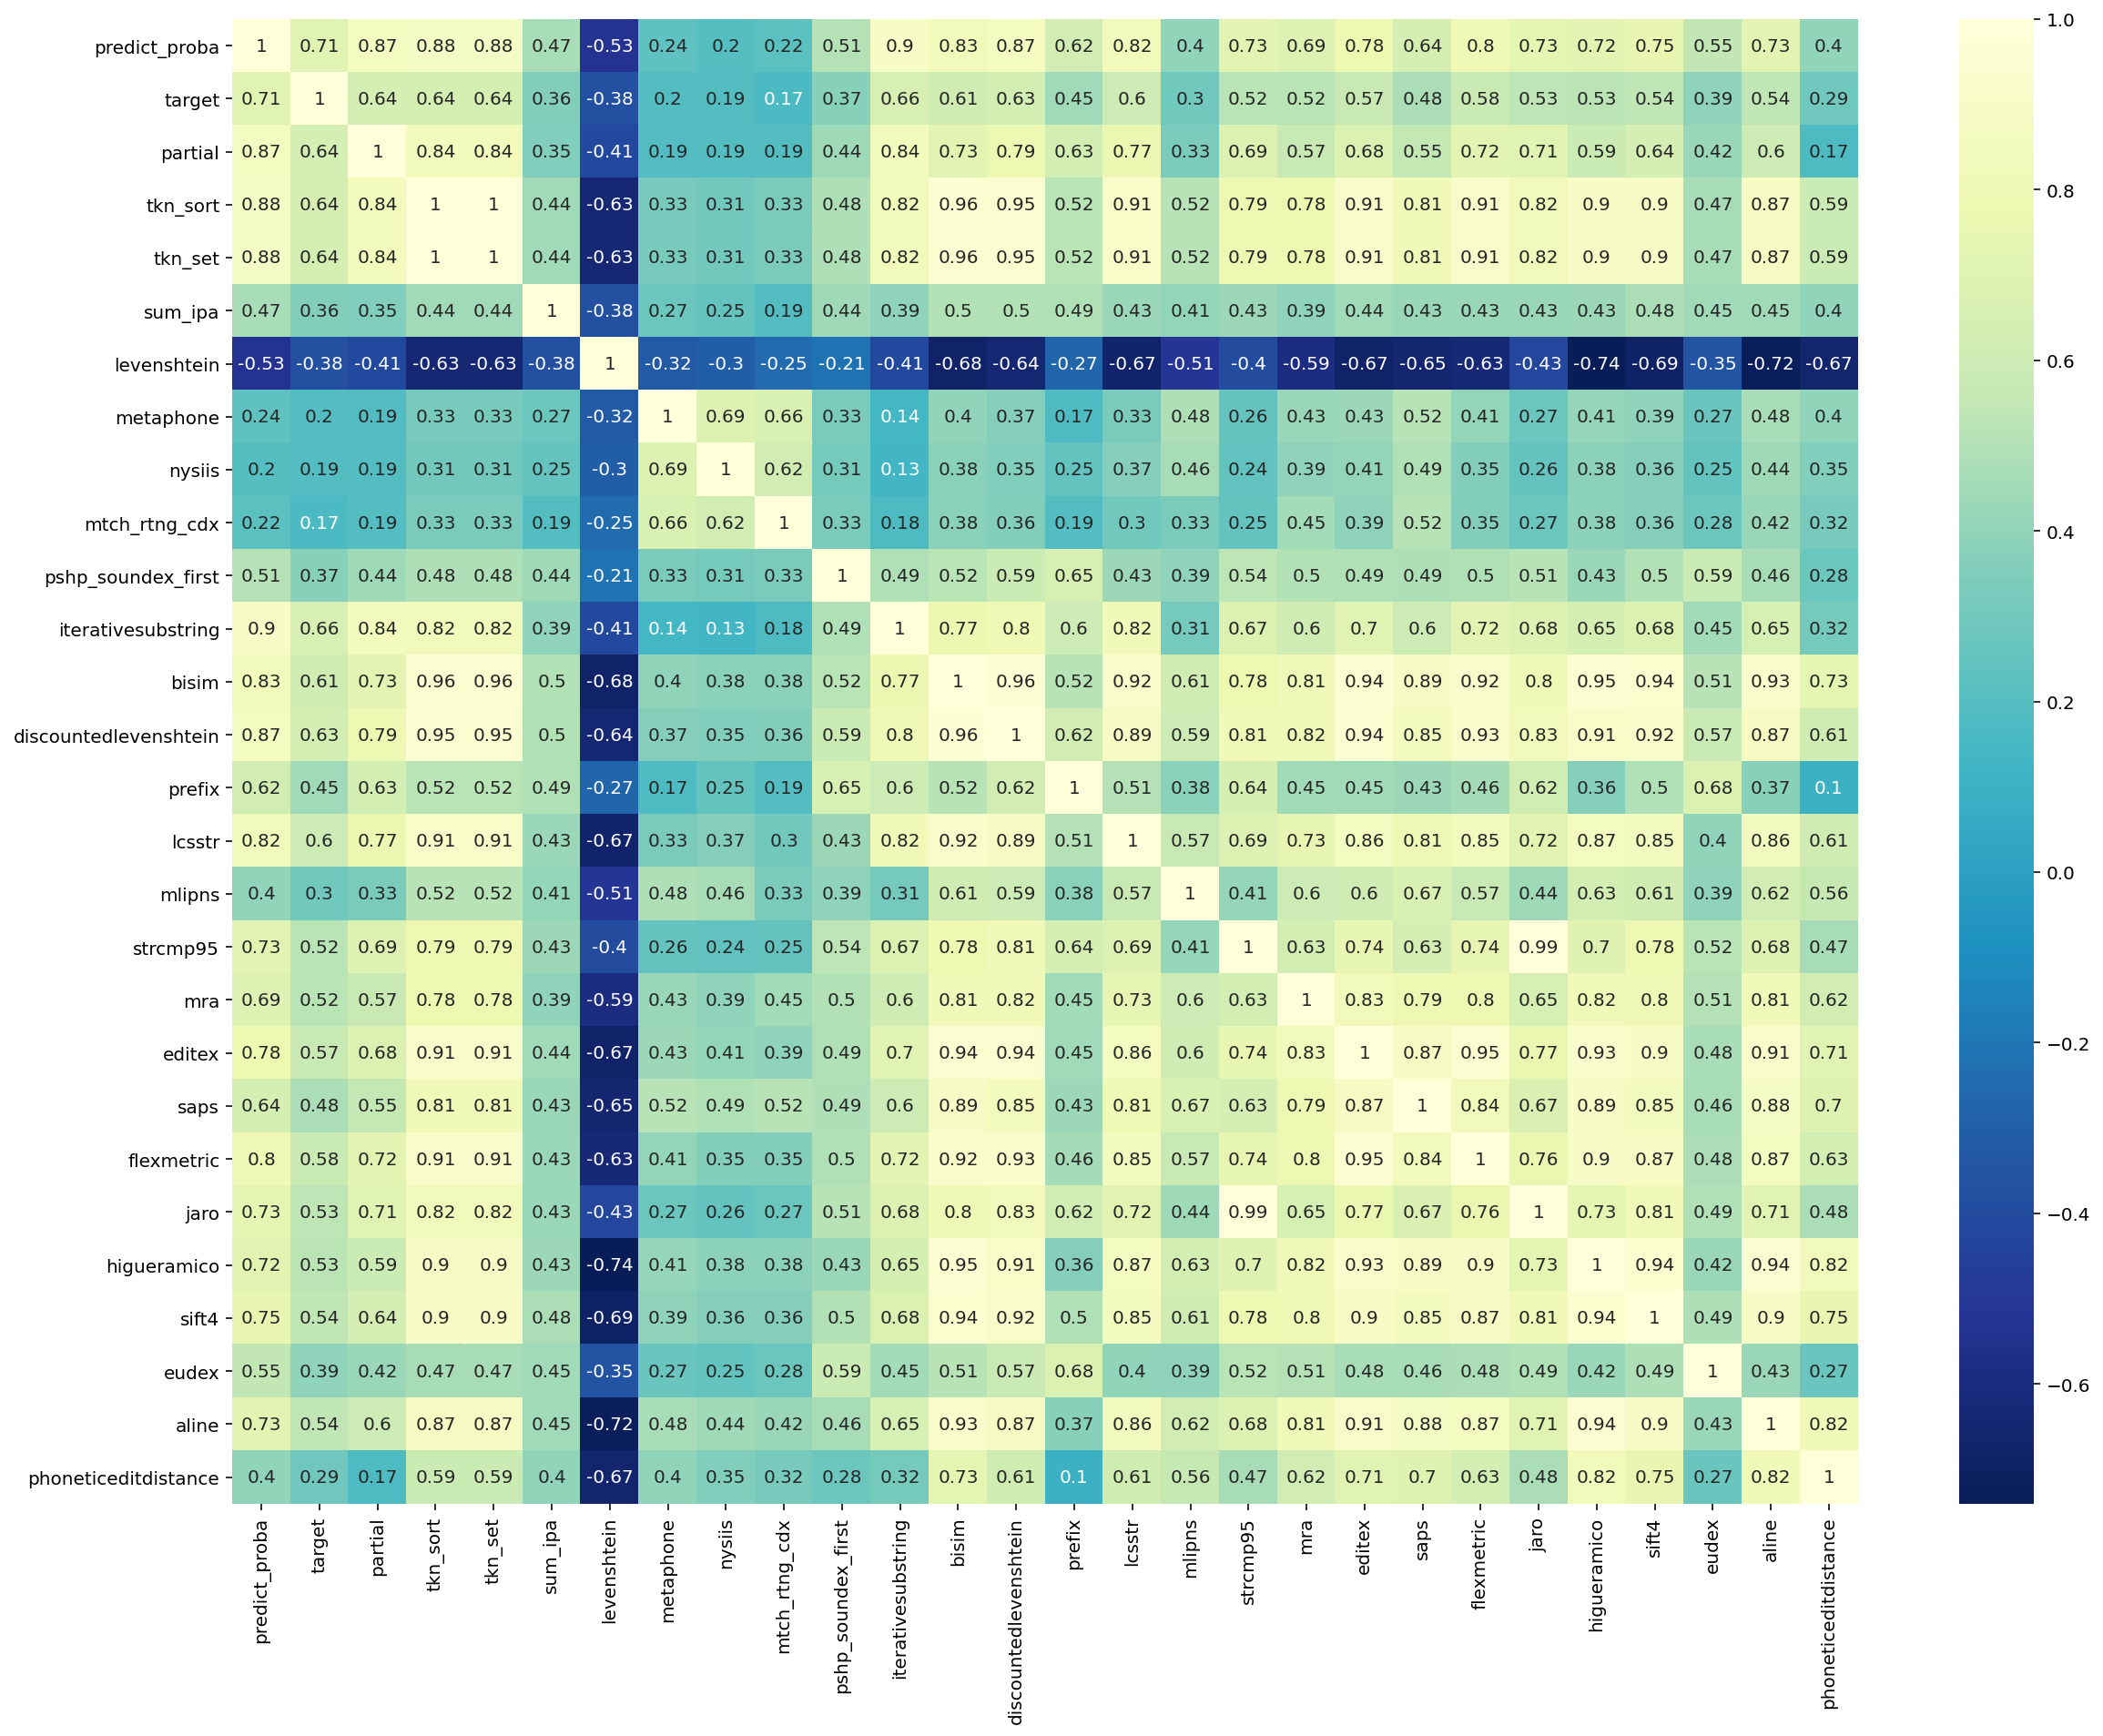

In [208]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot = True,
            cmap="YlGnBu_r")
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# XGboost

In [146]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

y = df.target
X = df.drop(columns = ['target','predict_proba'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [147]:
D_train = xgb.DMatrix(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_train)
D_test = xgb.DMatrix(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3}

steps = 20  # The number of training iterations

xgbmodel = xgb.train(param, D_train, steps)

In [148]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = xgbmodel.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.832716049382716
Recall = 0.8257453666398066
Accuracy = 0.8226950354609929


In [149]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=10)

grid.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_job...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [150]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open("Data.nosync/TM_XGboost_classifier.pkl", "wb"))

### Test saved model

In [151]:
import pickle
import numpy as np

# load the model from disk
loaded_model = pickle.load(open("Data.nosync/TM_XGboost_classifier.pkl", 'rb'))
result = loaded_model.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test)
print(result)

0.8297872340425532


In [152]:
proba_result = loaded_model.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

paa = [p[1] for p in proba_result]

paa




[0.28237584,
 0.90878284,
 0.083324626,
 0.87579745,
 0.05630275,
 0.658279,
 0.8941591,
 0.020235084,
 0.70344657,
 0.6603867,
 0.8167059,
 0.029872635,
 0.9281879,
 0.9421939,
 0.017149096,
 0.9110641,
 0.022211727,
 0.9152082,
 0.87885845,
 0.84330136,
 0.7840548,
 0.86848664,
 0.7719143,
 0.8122623,
 0.07594524,
 0.5635037,
 0.71979856,
 0.02371788,
 0.62428254,
 0.8940335,
 0.0271644,
 0.018758578,
 0.79073256,
 0.9087089,
 0.53416955,
 0.87279016,
 0.062266804,
 0.9034944,
 0.07265194,
 0.016387876,
 0.8512277,
 0.89544636,
 0.61216414,
 0.845238,
 0.69725406,
 0.71227473,
 0.6774507,
 0.016098628,
 0.8903764,
 0.79470354,
 0.016677493,
 0.016652245,
 0.42466968,
 0.923488,
 0.64353204,
 0.05720303,
 0.021496844,
 0.84703493,
 0.7212634,
 0.7870467,
 0.6481961,
 0.88721424,
 0.019267596,
 0.024851305,
 0.017795678,
 0.018087463,
 0.041610617,
 0.7774772,
 0.032297824,
 0.8980057,
 0.88443047,
 0.017486988,
 0.7859558,
 0.9027996,
 0.016677493,
 0.023625756,
 0.017840816,
 0.88198

In [153]:
loaded_model.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1])

In [154]:
# Import pandas library 
import pandas as pd 
  
# initialize list of lists 
data = [['Flipn Chicken','Frickn Chicken']] 
  
# Create the pandas DataFrame 
mydf = pd.DataFrame(data, columns = ['bboyaa', 'fdslkajsdf']) 
  
# print dataframe. 
mydf 

bboyaa      fdslkajsdf
0  Flipn Chicken  Frickn Chicken

In [155]:
featurize(mydf)

a               b          TM_A           TM_B  partial  \
0  Flipn Chicken  Frickn Chicken  flipnchicken  fricknchicken       75   

   tkn_sort  tkn_set   sum_ipa  iterativesubstring     bisim  \
0        80       80  0.972141            0.761313  0.769231   

   discountedlevenshtein    prefix    lcsstr  mlipns  strcmp95       mra  \
0               0.715296  0.083333  0.615385     0.0  0.805192  0.666667   

     editex      saps  flexmetric      jaro  higueramico     sift4     eudex  \
0  0.846154  0.604167    0.815385  0.767521     0.769231  0.769231  0.919608   

      aline  phoneticeditdistance  
0  0.812658              0.899504

In [156]:
foo = featurize(mydf)
foo2 = foo.drop(['a', 'b', 'TM_A', 'TM_B'], 1)

foo3 = loaded_model.predict_proba(foo2)

foo4 = [p[1] for p in foo3]

foo4

[0.935512]

In [157]:
def XGboost_ratio(data):
    df = featurize(data)
    df2 = df.drop(['a', 'b', 'TM_A', 'TM_B'], 1)
    df3 = loaded_model.predict_proba(df2)
    df4 = [p[1] for p in df3]
    return df4

In [158]:
XGboost_ratio(mydf)

[0.935512]

In [159]:
pd = pd.read_csv("Data.nosync/TM_clean_soundex.csv", index_col = False)

# df_matches = df[df.apply(get_ratio, axis = 1) > 70]

pd['wordmark']

0                                                      daisy
1                                                  budweiser
2                                       washburns gold medal
3                                                      giant
4                                                    welcome
                                 ...                        
1071622                                                  etf
1071623                                              europol
1071624                                   parati vero parati
1071625    organisation africaine de la propriete intelle...
1071626                 the great seal of the choctaw nation
Name: wordmark, Length: 1071627, dtype: object

### Evaluate XGboost

In [160]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.866')

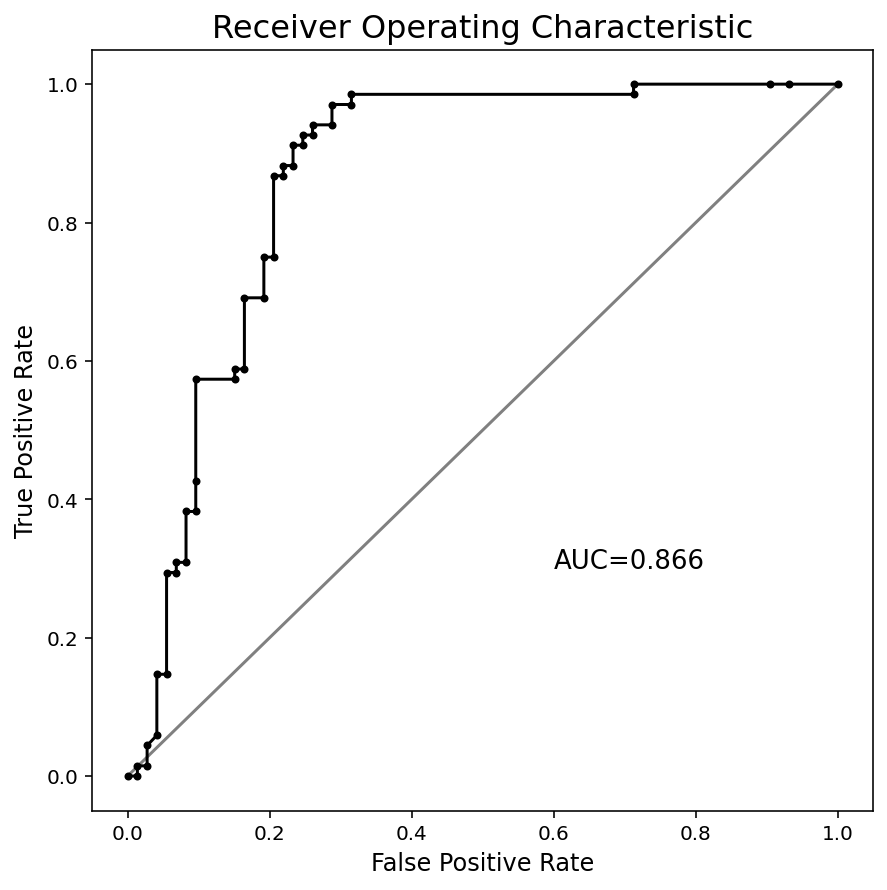

In [161]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('Figs/TM_XGBoost_ROC.png', dpi = 600)

In [162]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, best_preds))

print("Classification Report")
print(classification_report(y_test, best_preds))

Confusion Matrix:
[[54 19]
 [ 6 62]]
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.74      0.81        73
           1       0.77      0.91      0.83        68

    accuracy                           0.82       141
   macro avg       0.83      0.83      0.82       141
weighted avg       0.84      0.82      0.82       141



In [75]:
import joblib

xgbmodel.dump_model('Data.nosync/TM_XGBoost_model.pkl')

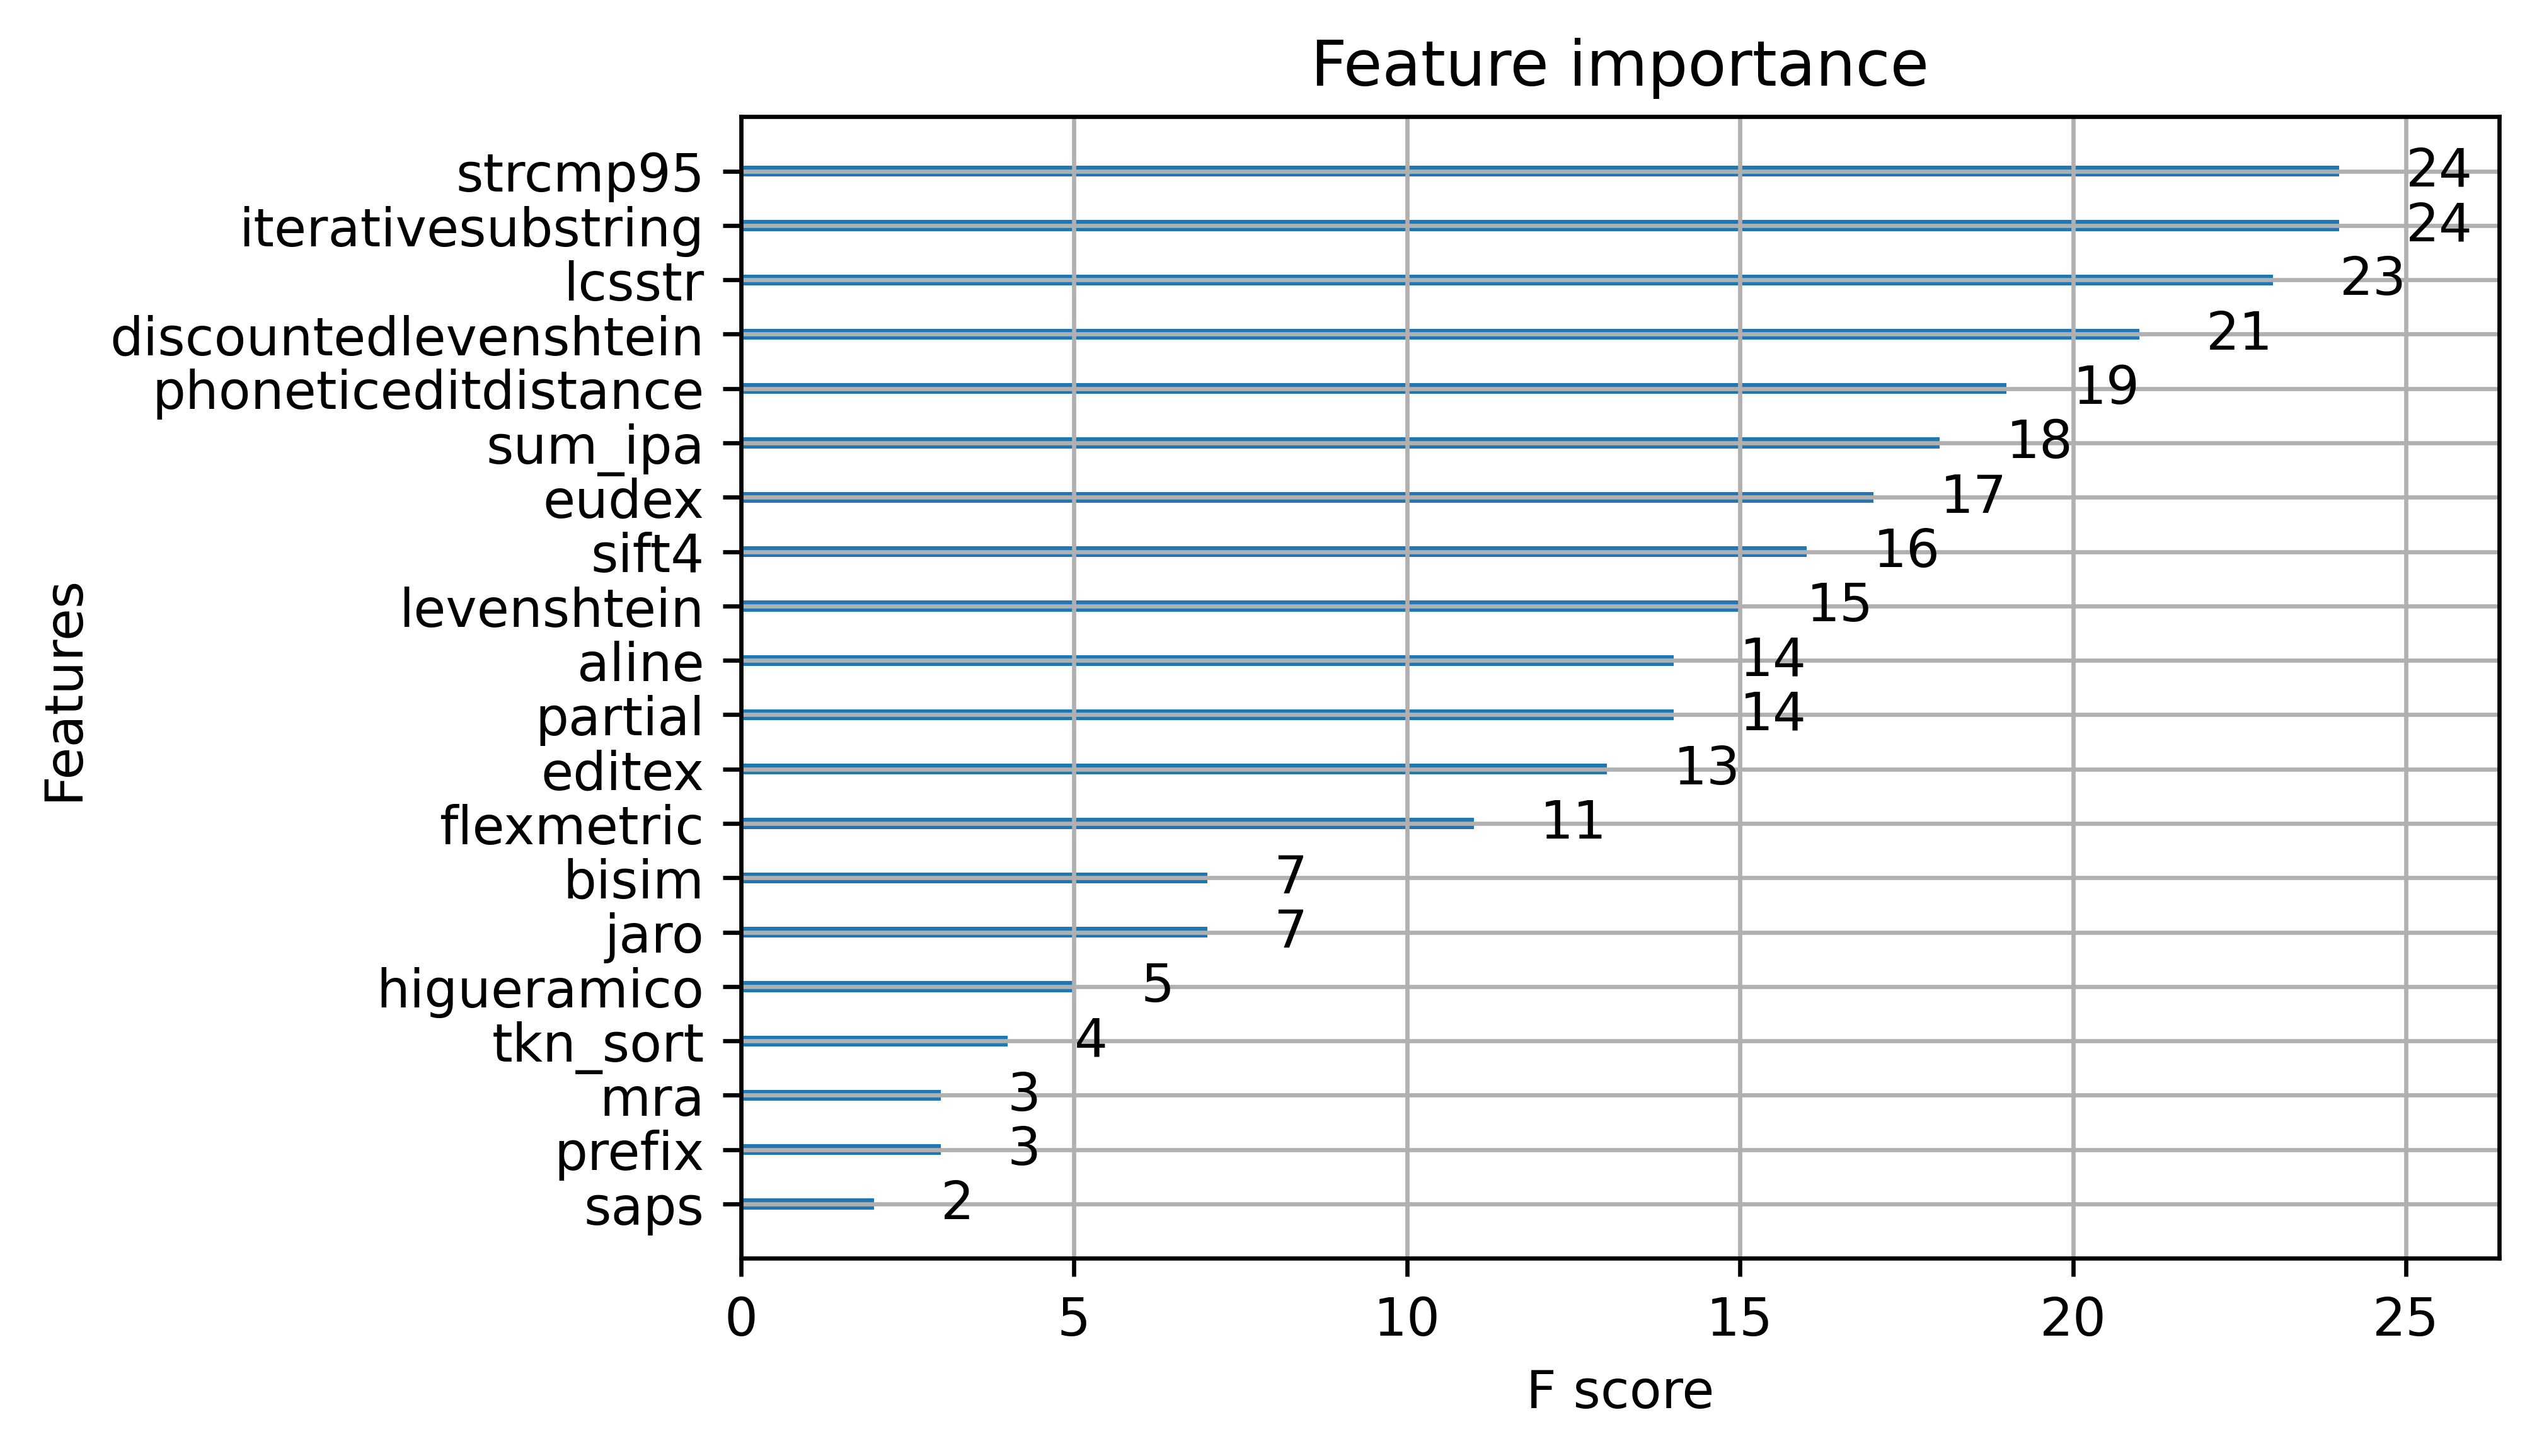

In [76]:
from xgboost import plot_importance
from matplotlib import pyplot

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

plot_importance(xgbmodel)
# pyplot.show()
# plt.savefig("Figs/TM_XGboost_feature_importance.png", format='png', dpi=600, bbox_inches='tight')

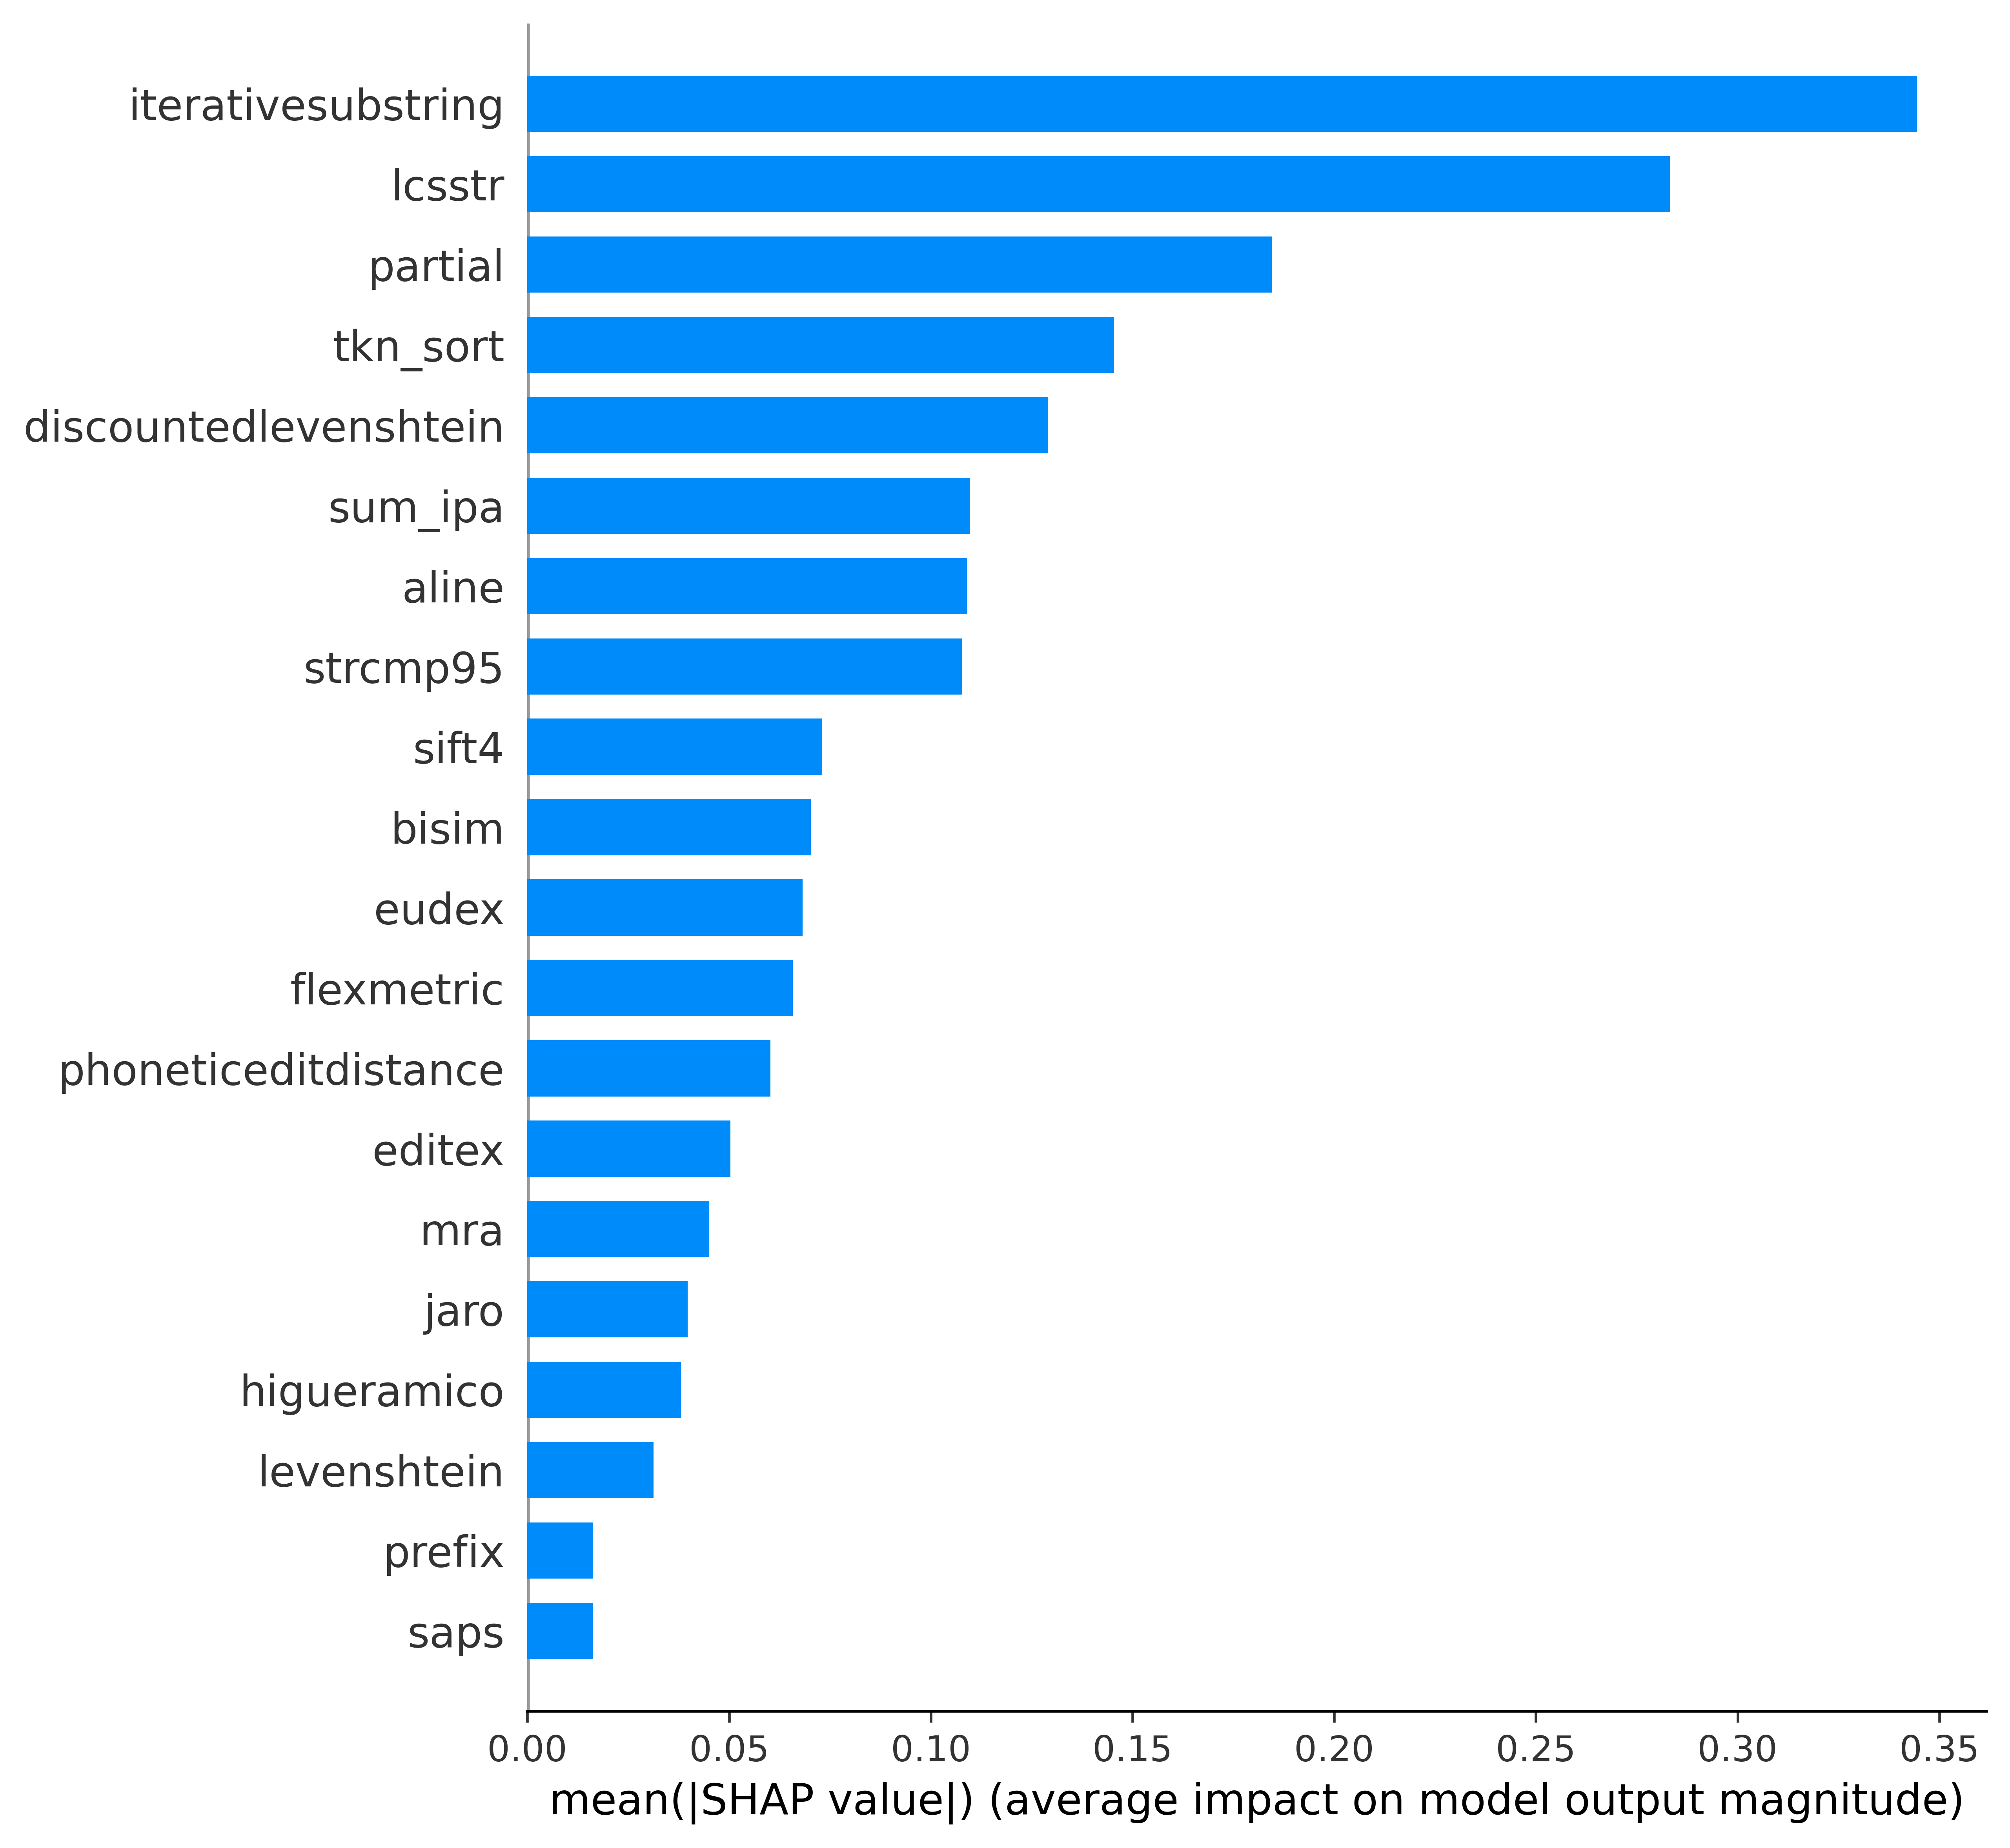

In [77]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


shap.summary_plot(shap_values[0], X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), plot_type="bar", show=False)
# plt.savefig("Figs/TM_XGboost_SHAP_features.png", format='png', dpi=600, bbox_inches='tight')

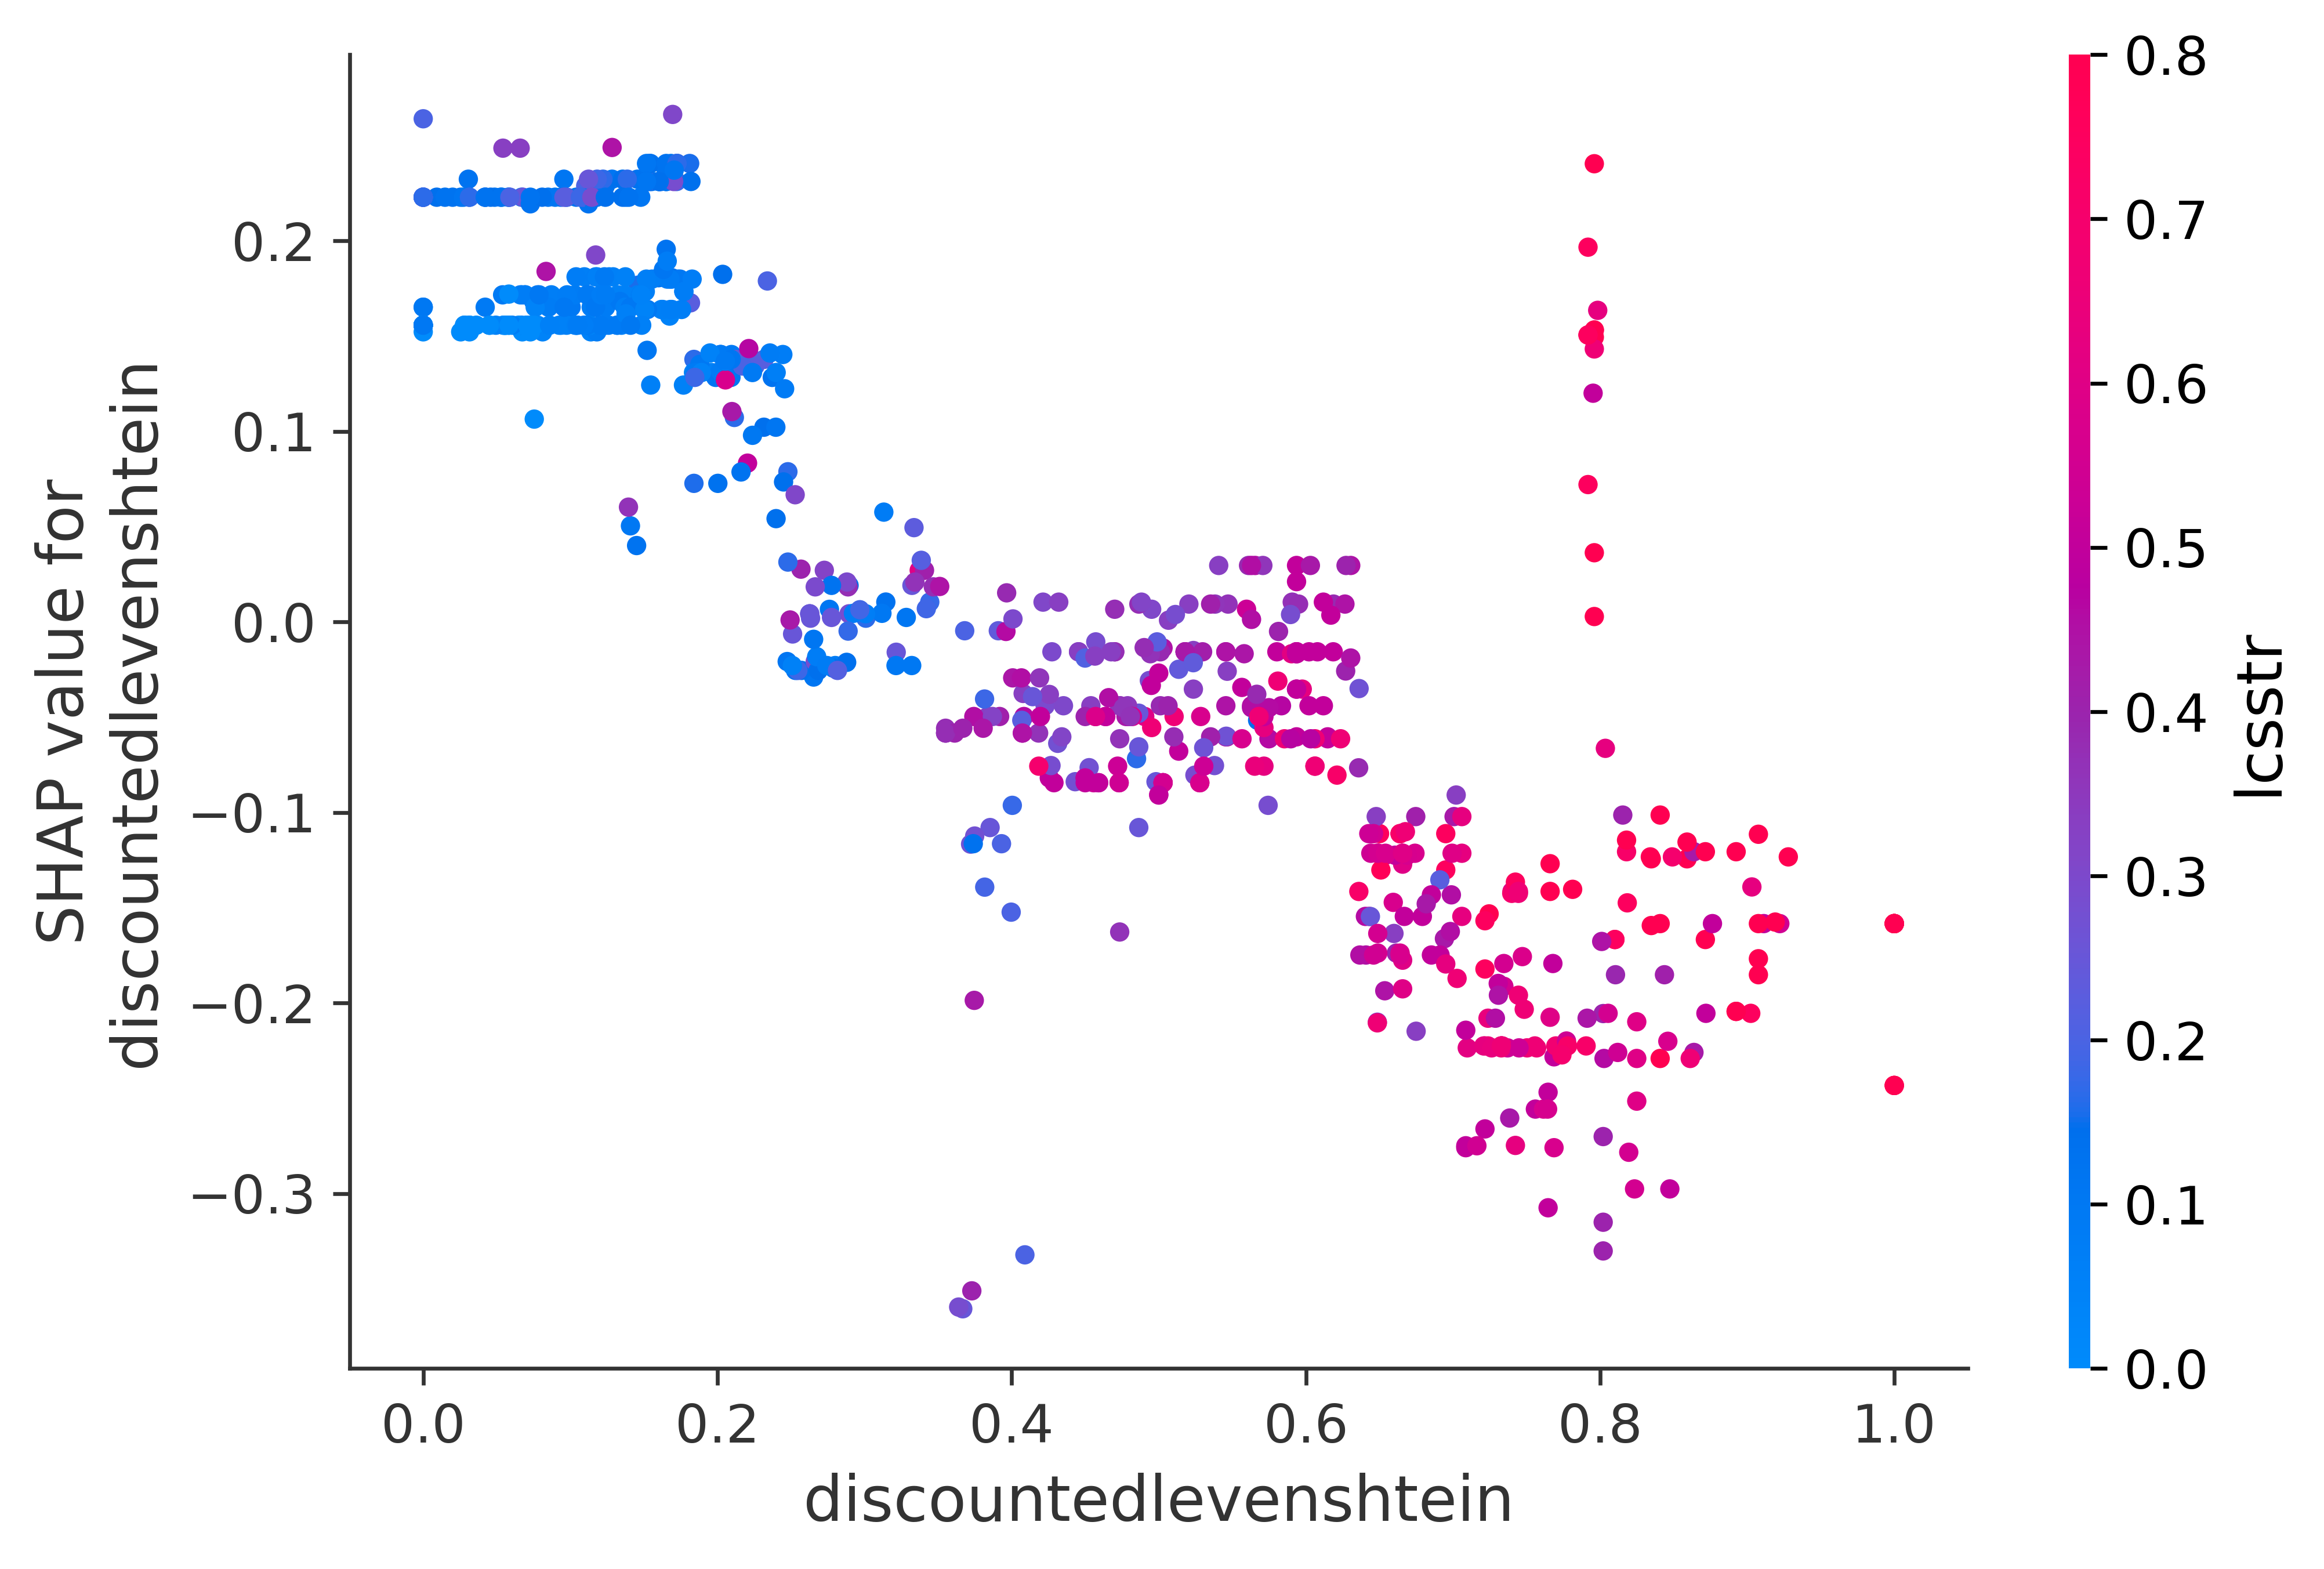

In [78]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("discountedlevenshtein", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


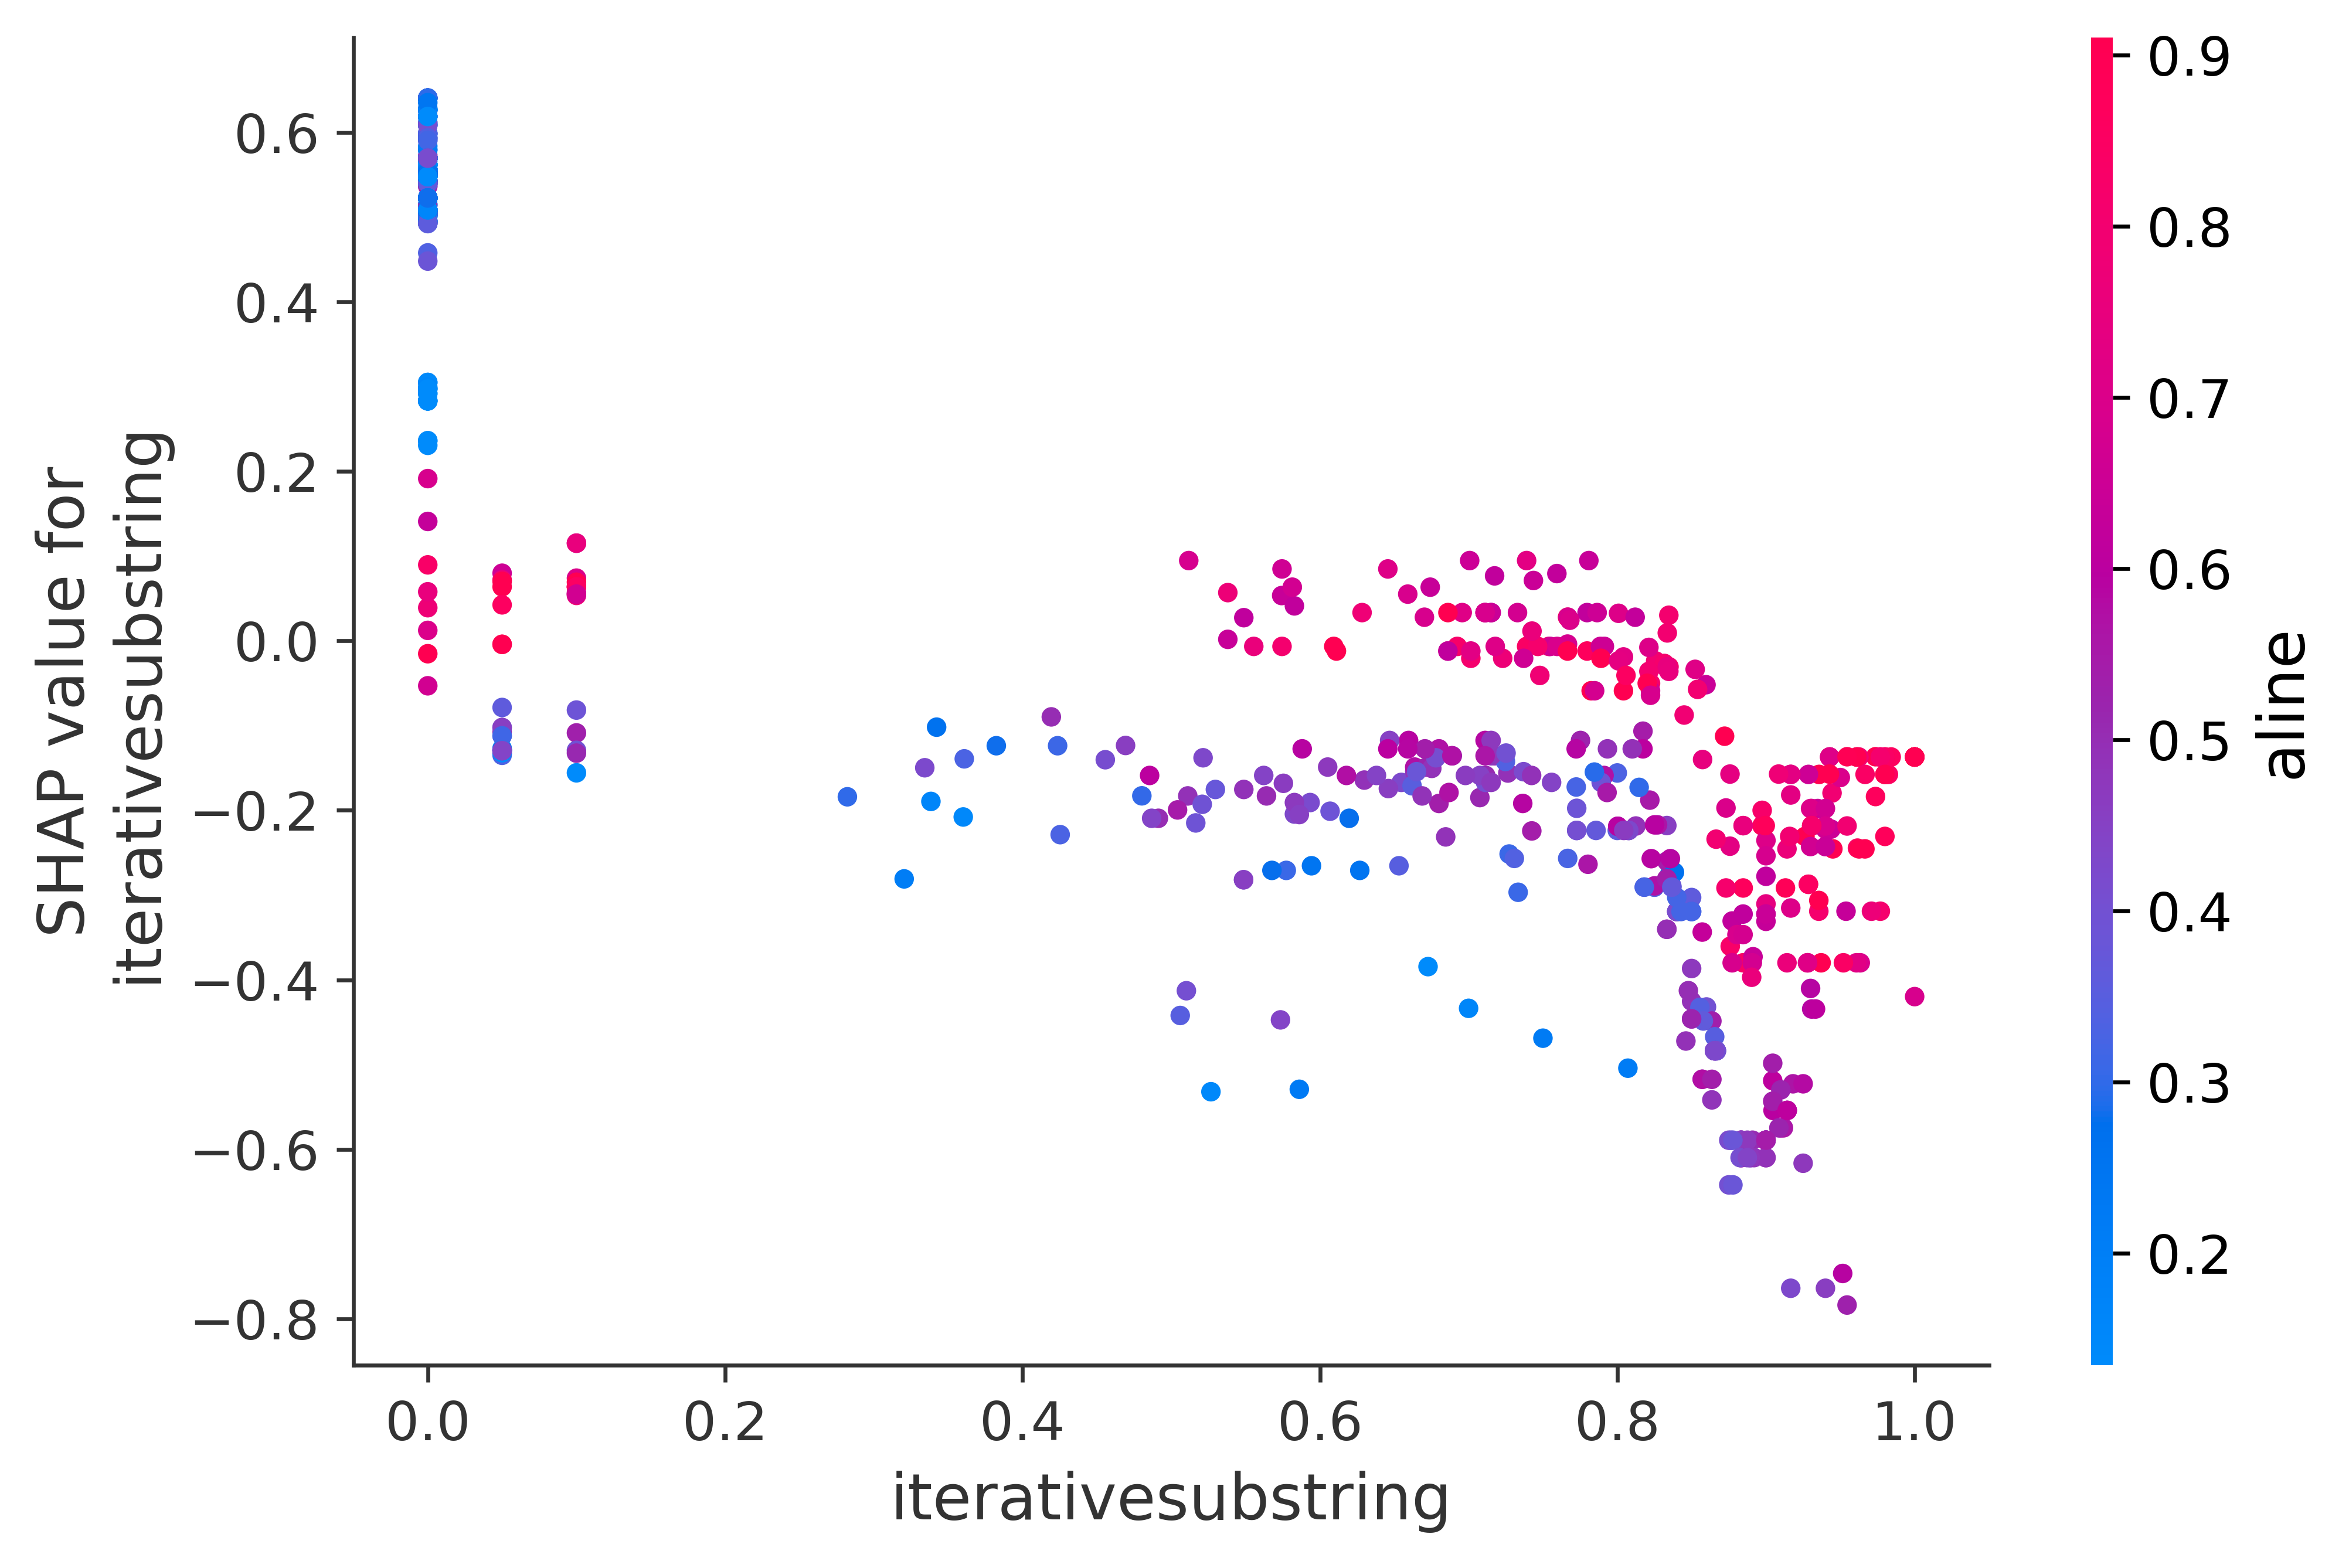

In [79]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("iterativesubstring", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


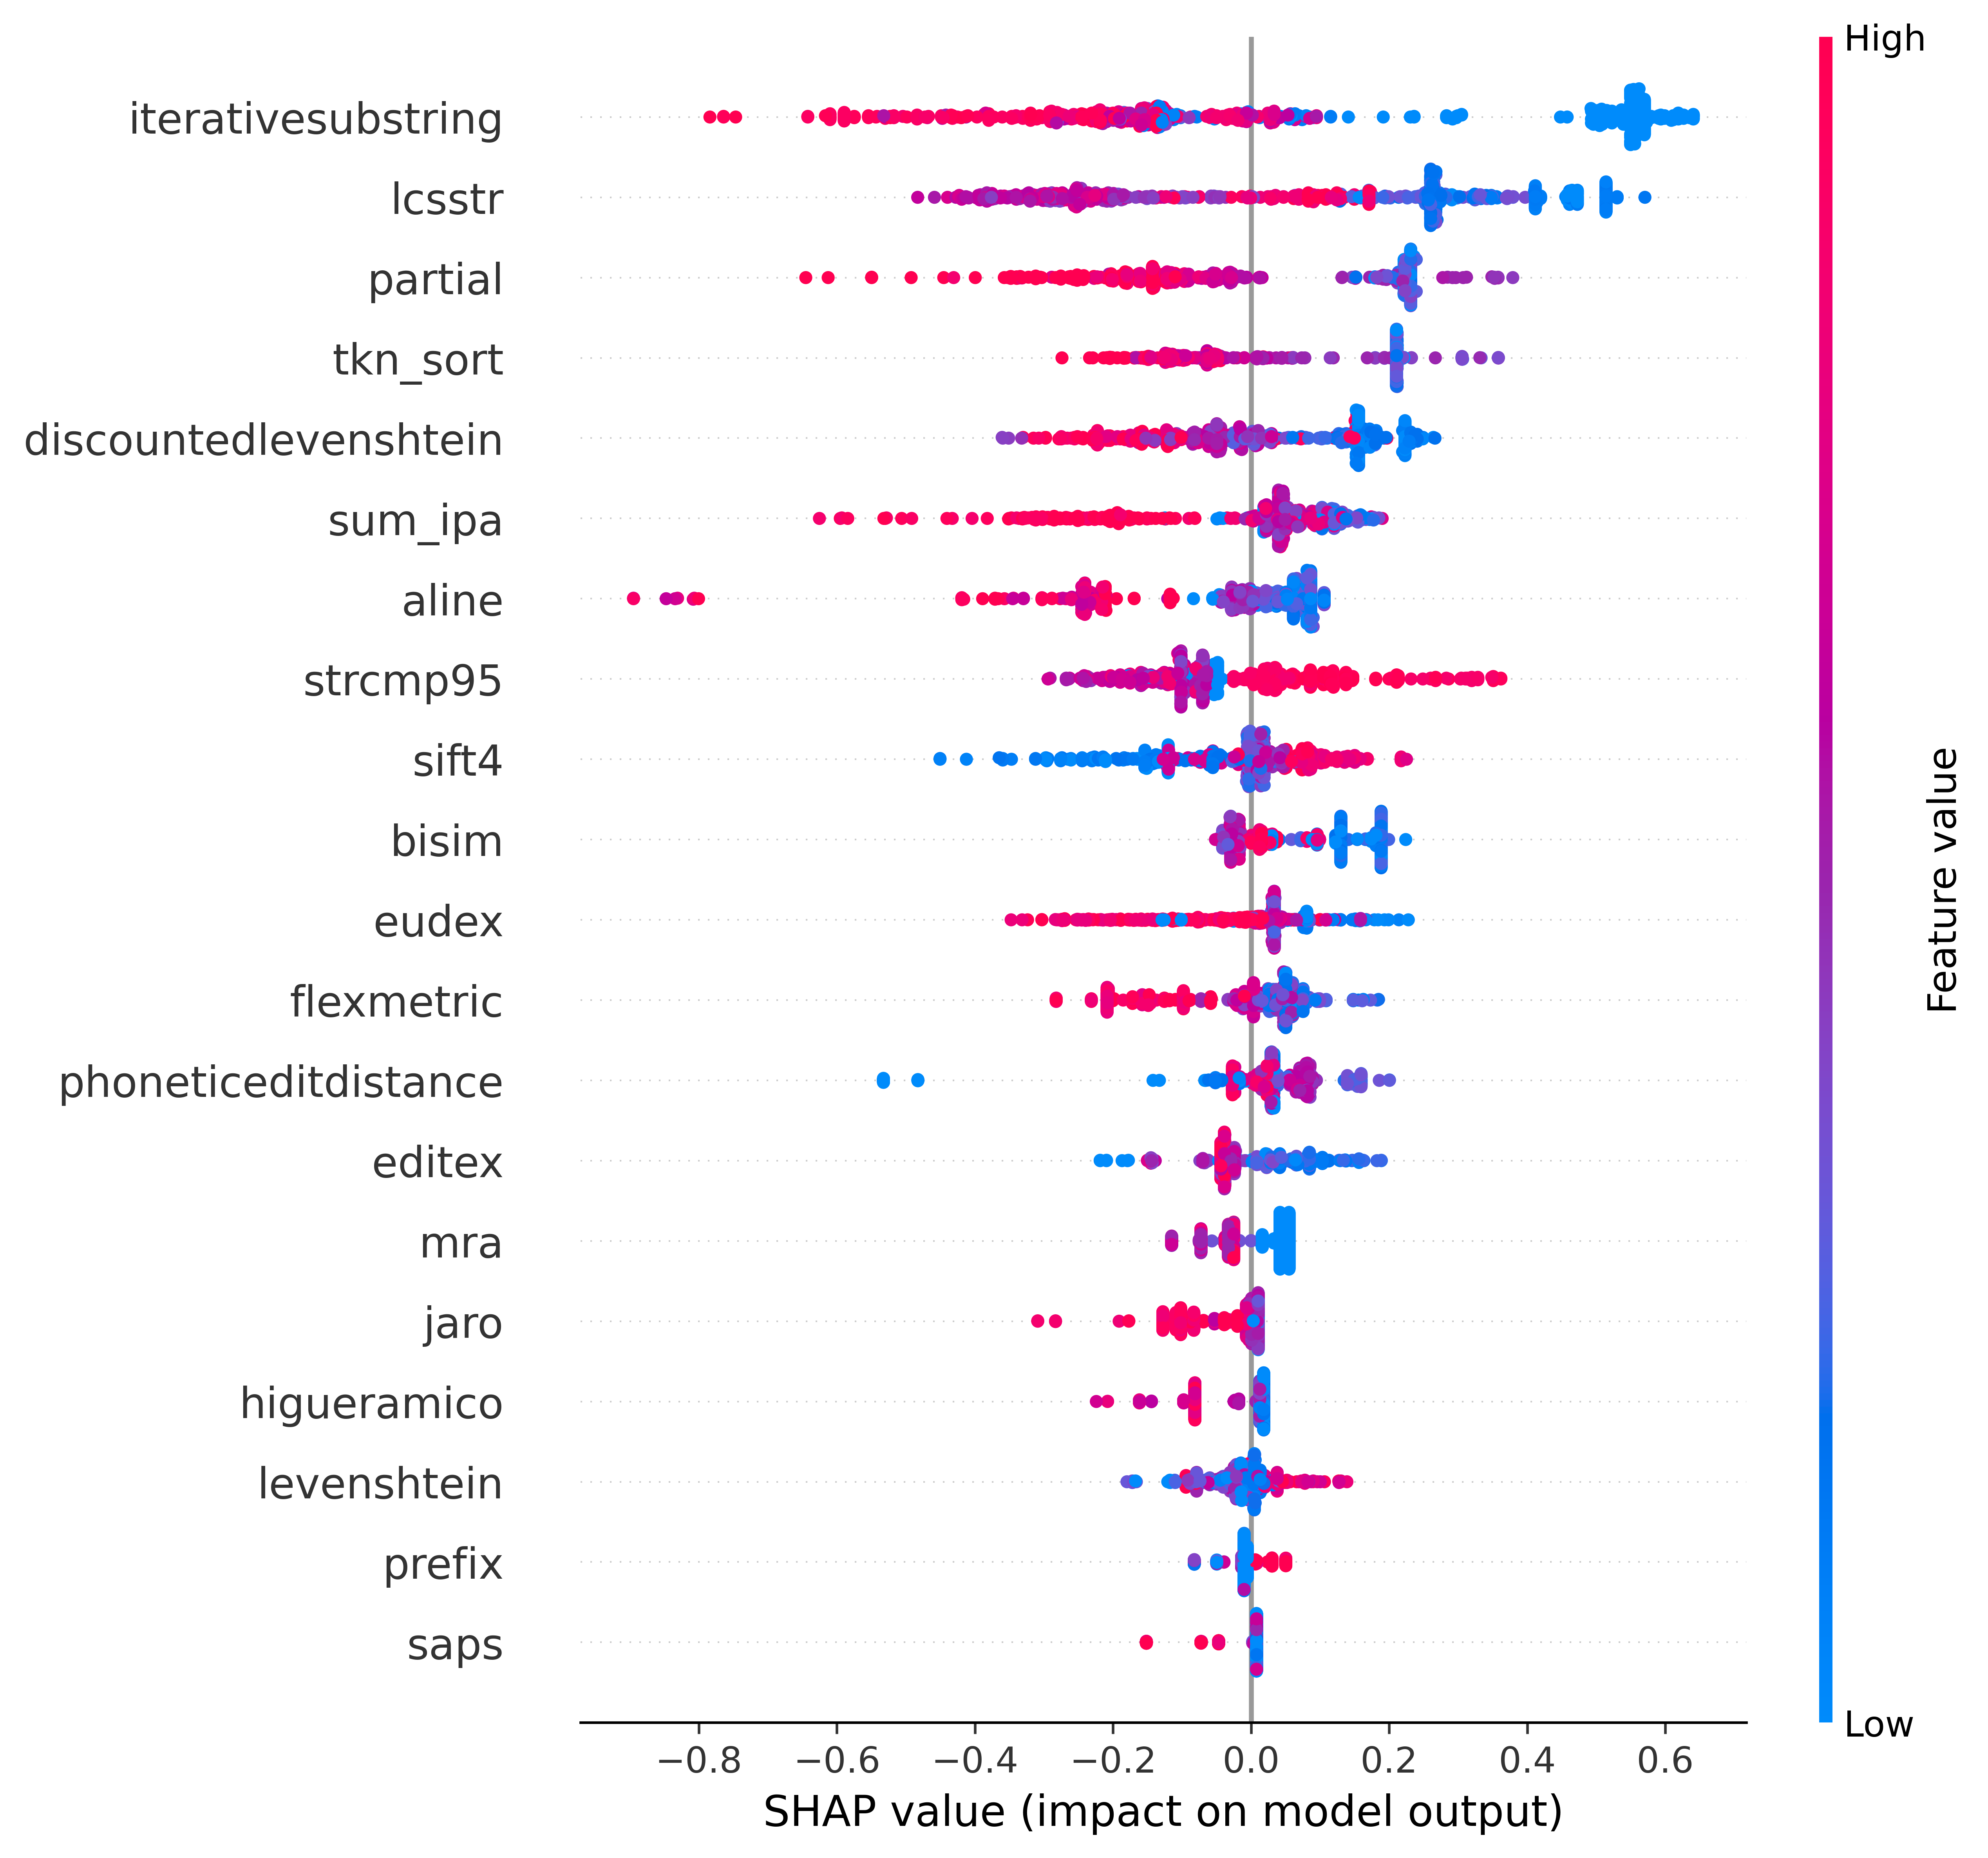

In [80]:
# summarize the effects of all the features
shap.summary_plot(shap_values[0],
                X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

# Grid Search   

Hyperparameter tuning

In [ ]:
cols = [col for col in df.columns if col not in ['a', 'b', 'TM_A', 'TM_B', 'target', 'predict_proba']]
comb2 = list(combinations(cols, 2))
comb3 = list(combinations(cols, 3))
colgrid = [(col,)for col in cols]+comb2+comb3


colgrid

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring = 'precision', verbose=0)

scores = []
for cols in colgrid:
    grid_clf.fit(X_train[['predict_proba']+list(cols)], y_train)
    y_pred = grid_clf.predict(X_val[['predict_proba']+list(cols)])
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    scores.append([str(cols), tn, fp, fn, tp])

In [ ]:
scores_df = pd.DataFrame(scores)

In [ ]:
scores_df.columns = ['features', 'tn', 'fp', 'fn', 'tp']

In [ ]:
scores_df.head()

In [ ]:
scores_df['error'] = scores_df['fp'] + scores_df['fn']

In [ ]:
scores_df = scores_df.sort_values(['error', 'fp'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)

In [ ]:
selected_cols = ['discountedlevenshtein', 'phoneticeditdistance', 'iterativesubstring', 'sum_ipa']

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring='precision')
grid_clf.fit(X_train[selected_cols], y_train)
y_pred = grid_clf.predict(X_test[selected_cols])

In [ ]:
print(grid_clf.best_params_)

## Evaluation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    print(classification_report(y_test, y_pred))
    print(conf_matrix)

In [ ]:
evaluate(y_test, y_pred)

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

### Export Models and Pipeline

In [ ]:
import joblib
import json

In [ ]:
base_1 = base_model_1(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y, X_test=None, export=True)
joblib.dump(base_1, filename='Data.nosync/TM_Gradient_boost_base_model.pkl')

In [ ]:
# base_model_2(X[['name_a', 'name_b']], y, X_test=None, export=True)

In [ ]:
joblib.dump(grid_clf.best_estimator_, filename='Data.nosync/TM_meta_model.pkl')